In [1]:
# !unzip ./food11.zip

In [2]:
import numpy as np
import os
import cv2
import time

In [3]:
def readfile(PATH,LABEL):
    image_dir = sorted(os.listdir(PATH))
    x = np.zeros((len(image_dir),128,128,3),dtype = np.uint8)
    y = np.zeros((len(image_dir)),dtype = np.int64)
    for i,FILE in enumerate(image_dir):
        img = cv2.imread(os.path.join(PATH,FILE))
        x[i,:,:] = cv2.resize(img,(128,128))
        if LABEL:
            y[i] = int(FILE.split('_')[0])
        if i % 1000 == 0:
            print(f'Read complete: {i}/{len(image_dir)}')
    if LABEL:
        return x,y
    else:
        return x

In [4]:
time_1 = time.time()
workspace_dir = './food-11/'
train_x,train_y = readfile(os.path.join(workspace_dir,'training'),True)
time_2 = time.time()
print(f'Size of training set = {len(train_x)}')
print('%2.2f sec(s)'.format(time_2-time_1))
val_x,val_y = readfile(os.path.join(workspace_dir,'validation'),True)
print(f'size of validation set = {len(val_x)}')
test_x = readfile(os.path.join(workspace_dir,'testing'),False)
print(f'Size of testing set = {len(test_x)}')

Read complete: 0/9866
Read complete: 1000/9866
Read complete: 2000/9866
Read complete: 3000/9866
Read complete: 4000/9866
Read complete: 5000/9866
Read complete: 6000/9866
Read complete: 7000/9866
Read complete: 8000/9866
Read complete: 9000/9866
Size of training set = 9866
%2.2f sec(s)
Read complete: 0/3430
Read complete: 1000/3430
Read complete: 2000/3430
Read complete: 3000/3430
size of validation set = 3430
Read complete: 0/3347
Read complete: 1000/3347
Read complete: 2000/3347
Read complete: 3000/3347
Size of testing set = 3347


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import time
import numpy as np
import pandas as pd
from PIL import Image

In [6]:
transforms_train = transforms.Compose([transforms.ToPILImage(),transforms.AutoAugment(),transforms.ToTensor()])
transforms_test = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
class ImgDataSetter(Dataset):
    def __init__(self,x,y = None,transform = None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X,Y
        else:
            return X

In [7]:
batch_size = 32
train_set = ImgDataSetter(train_x,train_y,transforms_train)
val_set = ImgDataSetter(val_x,val_y,transforms_test)
trn_loader = DataLoader(train_set,batch_size = batch_size,shuffle = True)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle = False)

In [28]:
class simpleClassifier(nn.Module):
    def __init__(self):
        super(simpleClassifier,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2,0),
        
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2,0),
        
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2,0),
        
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2,0),
        
            nn.Conv2d(512,512,3,1,1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2,0)
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,11)
        )
    def forward(self,x):
        out = self.cnn(x)
        out = out.view(out.size()[0],-1) # flatten
        return self.fc(out)

In [107]:
learning_rate = 2e-5
epoch_num = 15
val_acc_history = []
val_loss_history = []
train_acc_history = []
train_loss_history = []

model = simpleClassifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = learning_rate)
num_epoch = epoch_num


for epoch in range(epoch_num):
    epoch_start_time = time.time()
    epoch_train_time = time.time()
    val_acc = 0.0
    val_loss = 0.0
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for batch_id,DATA in enumerate(trn_loader):
        optimizer.zero_grad()
        train_pred = model(DATA[0].cuda())
        batch_loss = loss(train_pred,DATA[1].cuda())
        batch_loss.backward()
        optimizer.step()
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis = 1) == DATA[1].numpy())
        train_loss += batch_loss.item()
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        if batch_id % 100 == 0:
            print(f'training: batch#{batch_id}')

    epoch_eval_time = time.time()
    model.eval()
    with torch.no_grad():
        for i,DATA in enumerate(val_loader):
            val_pred = model(DATA[0].cuda())
            batch_loss = loss(val_pred,DATA[1].cuda())
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(),axis = 1) == DATA[1].numpy())
            val_loss += batch_loss.item()
            val_acc_history.append(val_acc)
            val_loss_history.append(val_loss)
            if batch_id % 100 == 0:
                print(f'validating: batch{batch_id}')
    print('[%03d/%03d] %2.4f sec(s),[Train]acc|loss|time: %3.6f|%3.6f|%2.4f sec(s),[Val]acc|loss|time: %3.6f|%3.6f|%2.4f sec(s)' % (epoch+1,epoch_num,time.time()-epoch_start_time,train_acc/train_set.__len__(),train_loss/train_set.__len__(),epoch_eval_time-epoch_train_time,val_acc/val_set.__len__(),val_loss/val_set.__len__(),time.time()-epoch_eval_time))

training: batch#0
training: batch#100
training: batch#200
training: batch#300
[001/015] 181.9769 sec(s),[Train]acc|loss|time: 0.245490|0.066584|165.5304 sec(s),[Val]acc|loss|time: 0.363265|0.057631|16.4465 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[002/015] 179.3160 sec(s),[Train]acc|loss|time: 0.350598|0.058947|163.5103 sec(s),[Val]acc|loss|time: 0.410787|0.053677|15.8056 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[003/015] 177.3424 sec(s),[Train]acc|loss|time: 0.412629|0.053774|161.0851 sec(s),[Val]acc|loss|time: 0.488047|0.046793|16.2573 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[004/015] 173.6710 sec(s),[Train]acc|loss|time: 0.443138|0.050350|157.5406 sec(s),[Val]acc|loss|time: 0.462099|0.050136|16.1305 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[005/015] 179.6485 sec(s),[Train]acc|loss|time: 0.477397|0.047917|164.

In [108]:
model = simpleClassifier().cuda()
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
 
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
         LeakyReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
      BatchNorm2d-10          [-1, 256, 32, 32]             512
        LeakyReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [109]:
device

device(type='cuda')

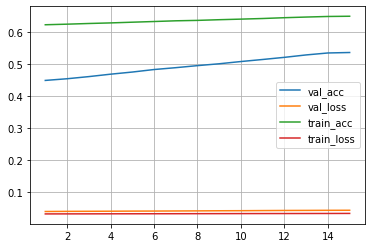

In [110]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = np.linspace(1,epoch_num,epoch_num)
x = x.transpose()
val_acc_history = np.array(val_acc_history) / val_set.__len__()
val_loss_history = np.array(val_loss_history) / val_set.__len__()
train_acc_history = np.array(train_acc_history) / train_set.__len__()
train_loss_history = np.array(train_loss_history) / train_set.__len__()
ax.plot(x,val_acc_history[-epoch_num:],label = 'val_acc')
ax.plot(x,val_loss_history[-epoch_num:],label = 'val_loss')
ax.plot(x,train_acc_history[-epoch_num:],label = 'train_acc')
ax.plot(x,train_loss_history[-epoch_num:],label = 'train_loss')
ax.grid()
ax.legend()

In [8]:
class Residual_Block(nn.Module):
    def __init__(self,i_channel,o_channel,stride = 1, down_sample = None):
        super(Residual_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = i_channel,out_channels = i_channel//4,kernel_size = 1,stride = 1,padding = 0)
        self.bn1 = nn.BatchNorm2d(i_channel//4)
        self.relu = nn.LeakyReLU(inplace = True)
        self.conv2 = nn.Conv2d(in_channels = i_channel//4,out_channels = i_channel//4,kernel_size = 3,stride = 1,padding = 1)
        self.bn2 = nn.BatchNorm2d(i_channel//4)
        self.conv3 = nn.Conv2d(in_channels = i_channel//4,out_channels = o_channel,kernel_size = 1,stride = 1,padding = 0)
        self.bn3 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample
    
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.down_sample:
            residual = self.down_sample(x)
        out += residual
        out = self.relu(out)
        
        return out

In [9]:
class Residual_Block(nn.Module):
    def __init__(self,i_channel,o_channel,stride = 1, down_sample = None):
        super(Residual_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = i_channel,out_channels = o_channel,kernel_size = 1,stride = stride,padding = 0)
        self.bn1 = nn.BatchNorm2d(o_channel)
        self.relu = nn.LeakyReLU(inplace = True)
        self.conv2 = nn.Conv2d(in_channels = o_channel,out_channels = o_channel,kernel_size = 3,stride = 1,padding = 1)
        self.bn2 = nn.BatchNorm2d(o_channel)
        self.down_sample = down_sample
    
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.down_sample:
            residual = self.down_sample(x)
        out += residual
        out = self.relu(out)
        
        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes = 11):
        super(ResNet,self).__init__()
        self.conv = nn.Conv2d(in_channels = 3,out_channels = 16,kernel_size = 3,stride = 1,padding = 1,bias = False)
        self.in_channels = 16
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(inplace = True)
        self.layer1 = self.make_layer(block,16,layers[0])
        self.layer2 = self.make_layer(block,32,layers[1],2)
        self.layer3 = self.make_layer(block,64,layers[2],2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(1024,num_classes)
        self.dropout = nn.Dropout(p = 0.5)
    
    def make_layer(self,block,out_channels,blocks,stride = 1):
        down_sample = None
        if (stride != 1) or (self.in_channels != out_channels):
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,kernel_size = 3,stride = stride,padding = 1,bias = False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels,out_channels,stride,down_sample))
        self.in_channels = out_channels
        for i in range(blocks-1):
            layers.append(block(out_channels,out_channels))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = self.dropout(out)
        out = out.view(out.size()[0],-1)
        out = self.fc(out)
        return out
    
def update_lr(optimizer,lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [14]:
batch_size = 32
train_set = ImgDataSetter(train_x,train_y,transforms_train)
val_set = ImgDataSetter(val_x,val_y,transforms_test)
trn_loader = DataLoader(train_set,batch_size = batch_size,shuffle = True)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle = False)

import random
random.seed(2)
epoch_num = 100
learning_rate = 1e-3
model = ResNet(Residual_Block,[4,4,4,4]).cuda()

from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
 
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]             272
       BatchNorm2d-5         [-1, 16, 128, 128]              32
         LeakyReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]           2,320
       BatchNorm2d-8         [-1, 16, 128, 128]              32
         LeakyReLU-9         [-1, 16, 128, 128]               0
   Residual_Block-10         [-1, 16, 128, 128]               0
           Conv2d-11         [-1, 16, 128, 128]             272
      BatchNorm2d-12         [-1, 16, 128, 128]              32
        LeakyReLU-13         [-1, 16, 128, 128]               0
           Conv2d-14         [-1, 16, 1

In [15]:
optimizer = torch.optim.AdamW(model.parameters(),lr = learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'max',factor = 0.5,patience = 20,verbose = True,threshold = 1e-4,threshold_mode = 'rel',cooldown = 0,min_lr = 0,eps = 1e-8)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 10,eta_min=0, last_epoch=-1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 400,gamma = 0.5,last_epoch=-1,verbose = False)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr = 0.01,total_steps = 1550,verbose = True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr = 3e-4,max_lr = 3e-3,mode = 'exp_range',gamma = 0.98,step_size_up = 10,cycle_momentum = False)
loss = nn.CrossEntropyLoss()

val_acc_history = []
val_loss_history = []
train_acc_history = []
train_loss_history = []

for epoch in range(epoch_num):
    epoch_start_time = time.time()
    epoch_train_time = time.time()
    val_acc = 0.0
    val_loss = 0.0
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for batch_id,DATA in enumerate(trn_loader):
        optimizer.zero_grad()
        train_pred = model(DATA[0].cuda())
        batch_loss = loss(train_pred,DATA[1].cuda())
        batch_loss.backward()
        optimizer.step()
        # scheduler.step(val_acc)
        scheduler.step()
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis = 1) == DATA[1].numpy())
        train_loss += batch_loss.item()
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        if batch_id % 100 == 0:
            print(f'training: batch#{batch_id}')

    epoch_eval_time = time.time()
    model.eval()
    with torch.no_grad():
        for i,DATA in enumerate(val_loader):
            val_pred = model(DATA[0].cuda())
            batch_loss = loss(val_pred,DATA[1].cuda())
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(),axis = 1) == DATA[1].numpy())
            val_loss += batch_loss.item()
            val_acc_history.append(val_acc)
            val_loss_history.append(val_loss)
            if batch_id % 100 == 0:
                print(f'validating: batch{batch_id}')
    print('[%03d/%03d] %2.4f sec(s),[Train]acc|loss|time: %3.6f|%3.6f|%2.4f sec(s),[Val]acc|loss|time: %3.6f|%3.6f|%2.4f sec(s)' % (epoch+1,epoch_num,time.time()-epoch_start_time,train_acc/train_set.__len__(),train_loss/train_set.__len__(),epoch_eval_time-epoch_train_time,val_acc/val_set.__len__(),val_loss/val_set.__len__(),time.time()-epoch_eval_time))

training: batch#0
training: batch#100
training: batch#200
training: batch#300
[001/100] 261.9524 sec(s),[Train]acc|loss|time: 0.196027|0.071355|237.0070 sec(s),[Val]acc|loss|time: 0.293003|0.063610|24.9453 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[002/100] 262.1641 sec(s),[Train]acc|loss|time: 0.250557|0.066326|237.0632 sec(s),[Val]acc|loss|time: 0.339650|0.058968|25.1009 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[003/100] 259.9830 sec(s),[Train]acc|loss|time: 0.285526|0.063675|234.4951 sec(s),[Val]acc|loss|time: 0.370845|0.056319|25.4879 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[004/100] 254.7451 sec(s),[Train]acc|loss|time: 0.311879|0.061709|229.2183 sec(s),[Val]acc|loss|time: 0.394169|0.054743|25.5268 sec(s)
training: batch#0
training: batch#100
training: batch#200
training: batch#300
[005/100] 259.6132 sec(s),[Train]acc|loss|time: 0.332658|0.059791|234.

In [16]:
len(trn_loader)

309

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


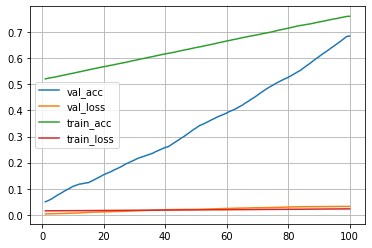

In [17]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x = np.linspace(1,epoch_num,epoch_num)
x = x.transpose()
val_acc_history = np.array(val_acc_history) / val_set.__len__()
val_loss_history = np.array(val_loss_history) / val_set.__len__()
train_acc_history = np.array(train_acc_history) / train_set.__len__()
train_loss_history = np.array(train_loss_history) / train_set.__len__()
ax.plot(x,val_acc_history[-epoch_num:],label = 'val_acc')
ax.plot(x,val_loss_history[-epoch_num:],label = 'val_loss')
ax.plot(x,train_acc_history[-epoch_num:],label = 'train_acc')
ax.plot(x,train_loss_history[-epoch_num:],label = 'train_loss')
ax.grid()
ax.legend()